### permanava analysis on environmental factors and microbiome
---


In [3]:
#setworking directory to AbioticAraMicrobe/
setwd('../')

In [4]:
#load packages
library(reshape2)
library(vegan)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(leaps)

### normalize environmental data(z-transformation)

In [5]:
#preapare environmental factor as a raw data and normalize one. both in spread form which environmental factors are in different columns and the valus are identical based on different "site_season_year"
library(tidyr)
env_data <- read.table("data/environmental_data.txt" , header = TRUE)
env_data <- separate(data = env_data , col = variable , into = c("Month1" , "Season") , sep = "_" , remove = FALSE)
d1 <- data.frame("envdata"=unique(env_data$env_factor))
#add full names of env factors
d1$environmentalfactor <- c("Precipitation" , "Vapor_Pressure_Deficit" , "Palmer_Drought_Severity_Index" , "Soil_Moisture" , "Runoff" , "Downward_Surface_Shortwave_Radiation" , "Climate_Water_Deficit" , "Actual_Evapotranspiration" , "Vapor_Pressure" , 
                            "Min_Temperature" , "Snow_Water_Equivalent" , "Potential_Evapotranspiration" , "Max_Temperature" , "Wind_Speed")
d1$environmentalfactor = gsub("Downward_Surface_Shortwave_Radiation" ,"Radiation" , d1$environmentalfactor)
d1$environmentalfactor = gsub("Palmer_Drought_Severity_Index" ,"Drought" , d1$environmentalfactor)
head(d1)

env_data <- merge(env_data , d1 , by.x = "env_factor" , by.y = "envdata")
env_data$env_value = env_data$value
env_data$season_site <- paste(env_data$Season,env_data$Site)
env_data$site_season_year = paste(env_data$Site , env_data$Season , env_data$Year , sep = "_" )###########################################data1
env_data$site_season_year_env = paste(env_data$Site , env_data$Season , env_data$Year,env_data$environmentalfactor , sep = "_" )
#head(env_data)

#spread env data in different columns
env_data_count <- env_data[c("site_season_year" , "environmentalfactor" , "env_value")] %>% spread(environmentalfactor,env_value) ########################data2
#head(env_data_count)

#normalized env data 
#normalize the environmental data , first group them then do normalization this is z transformation 
stdize=function(x) {(x - mean(x))/sd(x)}
#stdize=function(x) {log10((x/sum(x))+1)}
env_data_norm <- data.frame(env_data_count[1] , apply(env_data_count[2:ncol(env_data_count)] ,2, stdize)) #2 is the margin , apply on the columns ########################data3
#env_data_norm = env_data_count
#head(env_data_norm)
env_data_melt <- melt(env_data_norm ,id ="site_season_year" ,   variable.name = "env_factor" , value.name = "env_value_norm")
env_data_melt$site_season_year_env = paste(env_data_melt$site_season_year,env_data_melt$env_factor , sep = "_" )
env_data_melt <- merge(y =env_data[c("Site" , "Season" , "Year" , "env_value"  , "season_site" ,"site_season_year_env")],x=env_data_melt , by = "site_season_year_env") #########################data4
#head(env_data_melt)
#load microbiome data


head(env_data_melt)



,envdata,environmentalfactor
,<chr>,<chr>
1,ppt,Precipitation
2,vpd,Vapor_Pressure_Deficit
3,PDSI,Drought
4,soil,Soil_Moisture
5,q,Runoff
6,srad,Radiation


,site_season_year_env,site_season_year,env_factor,env_value_norm,Site,Season,Year,env_value,season_site
,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>
1,ERG_Fall_2014_Actual_Evapotranspiration,ERG_Fall_2014,Actual_Evapotranspiration,-0.79264527,ERG,Fall,2014,16.90,Fall ERG
2,ERG_Fall_2014_Climate_Water_Deficit,ERG_Fall_2014,Climate_Water_Deficit,-0.44148181,ERG,Fall,2014,0.00,Fall ERG
3,ERG_Fall_2014_Drought,ERG_Fall_2014,Drought,1.75890428,ERG,Fall,2014,2.48,Fall ERG
4,ERG_Fall_2014_Max_Temperature,ERG_Fall_2014,Max_Temperature,0.05012492,ERG,Fall,2014,9.83,Fall ERG
5,ERG_Fall_2014_Min_Temperature,ERG_Fall_2014,Min_Temperature,0.99069671,ERG,Fall,2014,3.45,Fall ERG
6,ERG_Fall_2014_Potential_Evapotranspiration,ERG_Fall_2014,Potential_Evapotranspiration,-0.83417305,ERG,Fall,2014,16.90,Fall ERG


---
### open Bacteria otu table and calculate permanova to see effects of environmental factors on variation of microbiome
---

In [8]:
#make log10 transform file of relative abundance otu table
data <- read.table("data/DataClean/BV5Otu.txt" , header = T)
firstotuname = "Otu000002"
#head(data)
rownames(data) <- data$Samplenumber
n <- which(colnames(data)==firstotuname)
data1 <- data[-c(1:n-1)]
metadata = data[c(1:n-1)]
metadata$site_season_year <- paste(metadata$Site , metadata$Season , metadata$Year , sep = "_")
metadata$Comp_Season <- paste(metadata$Compartment , metadata$Season, sep = "")
d1 <- metadata
metada_env_data_norm <- merge(d1,env_data_norm , by = "site_season_year" )
rownames(metada_env_data_norm) = metada_env_data_norm$Samplenumber
metadata <- metadata[c("Samplenumber" , "site_season_year" , "Lib" , "Run" , "Infection" , "Compartment")]

metadata <- merge(metadata , env_data_melt , by = "site_season_year")
log_transform=function(x) {log10((x/rowSums(x))+1)}
#log_transform=function(x) {(x/rowSums(x))}
log_data <- log_transform(data1)
ado_data <- merge(metada_env_data_norm , log_data , by = "row.names")
rownames(ado_data) <- ado_data$Row.names
firstotuname = "Otu000002"
n <- which(colnames(ado_data)==firstotuname)
n
ado_data1 <- ado_data[-c(1:n-1)]
ado_sample <- ado_data[c(1:n-1)]
ado_sample$Comp_Season <- paste(ado_sample$Compartment , ado_sample$Season , sep ="")
ado_sample = ado_sample[,c(18:ncol(ado_sample))]
identical(rownames(ado_data1) , rownames(ado_sample))



[1] 32

[1] TRUE

In [7]:
head(ado_sample)
dim(ado_sample)

,Actual_Evapotranspiration,Climate_Water_Deficit,Drought,Max_Temperature,Min_Temperature,Potential_Evapotranspiration,Precipitation,Radiation,Runoff,Snow_Water_Equivalent,Soil_Moisture,Vapor_Pressure,Vapor_Pressure_Deficit,Wind_Speed
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S1,0.5270238,3.1101405,0.2577705,1.47001928,0.5502336,1.2063660,-1.5401224,1.5005998,-0.83661192,-0.2888801,-1.0132627,-0.006000963,2.2689341,-0.7396354
S10,-0.7986988,-0.4414818,1.8377309,0.23895998,1.2944643,-0.8397636,0.4012907,-0.8917336,1.91922698,-0.2888801,0.5474292,1.364988242,-0.3218903,-1.8646650
S100,-0.7926453,-0.4414818,1.7589043,0.05012492,0.9906967,-0.8341730,0.8456586,-0.8763182,2.59656570,-0.2888801,0.4487293,1.202500633,-0.5291563,-1.6448317
S101,-0.7926453,-0.4414818,1.7589043,0.05012492,0.9906967,-0.8341730,0.8456586,-0.8763182,2.59656570,-0.2888801,0.4487293,1.202500633,-0.5291563,-1.6448317
S102,-0.7926453,-0.4414818,1.7589043,0.05012492,0.9906967,-0.8341730,0.8456586,-0.8763182,2.59656570,-0.2888801,0.4487293,1.202500633,-0.5291563,-1.6448317
S103,-1.6340856,-0.4414818,1.4881518,-2.25947306,-2.4975683,-1.6112550,-0.8368994,-0.2359833,-0.08622687,4.7885010,0.4487293,-1.874608472,-1.2545871,-0.5327334


### calculate permanova for each environmental factor separately

In [10]:
adores = data.frame()
for (i in names(ado_sample)){
     d1 =  setNames(ado_sample[i], c('var'))
     adonis <- adonis2(ado_data1  ~  var, data = d1, permutations = 10000, method = 'bray' , parallel = 4)   
     adonis$var = i
    adores = rbind(adores,adonis)
}

adores$taxa = "Bacteria"
adores1B =  adores %>% drop_na()
adores1B = adores1B[order(adores1B$R2,decreasing = TRUE),]
adores1B
sum(adores1B$R2) * 100




,Df,SumOfSqs,R2,F,Pr(>F),var,taxa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
var7,1,5.6490345,0.024500797,17.505966,0.00009999,Radiation,Bacteria
var11,1,3.6092973,0.015654119,11.084438,0.00009999,Vapor_Pressure,Bacteria
var6,1,3.2041085,0.013896749,9.822535,0.00009999,Precipitation,Bacteria
var5,1,3.0923066,0.013411845,9.475135,0.00009999,Potential_Evapotranspiration,Bacteria
var,1,3.0628088,0.013283909,9.383534,0.00009999,Actual_Evapotranspiration,Bacteria
var8,1,2.9916818,0.012975419,9.162758,0.00009999,Runoff,Bacteria
var12,1,2.6011869,0.011281778,7.953125,0.00009999,Vapor_Pressure_Deficit,Bacteria
var10,1,2.1344537,0.009257479,6.512755,0.00009999,Soil_Moisture,Bacteria
var4,1,2.0806276,0.009024026,6.347022,0.00009999,Min_Temperature,Bacteria


[1] 15.64256

---
### open Fungi otu table and calculate permanova to see effects of environmental factors on variation of microbiome
---

In [7]:
#FUNGI

data <- read.table("data/DataClean/FITS2Otu.txt" , header = T)
firstotuname = "Otu00002"
#head(data)
rownames(data) <- data$Samplenumber
n <- which(colnames(data)==firstotuname)
data1 <- data[-c(1:n-1)]
metadata = data[c(1:n-1)]
metadata$site_season_year <- paste(metadata$Site , metadata$Season , metadata$Year , sep = "_")
metadata$Comp_Season <- paste(metadata$Compartment , metadata$Season, sep = "")
d1 <- metadata
metada_env_data_norm <- merge(d1,env_data_norm , by = "site_season_year" )
rownames(metada_env_data_norm) = metada_env_data_norm$Samplenumber
metadata <- metadata[c("Samplenumber" , "site_season_year" , "Lib" , "Run" , "Infection" , "Compartment")]

metadata <- merge(metadata , env_data_melt , by = "site_season_year")
log_transform=function(x) {log10((x/rowSums(x))+1)}
#log_transform=function(x) {(x/rowSums(x))}
log_data <- log_transform(data1)
ado_data <- merge(metada_env_data_norm , log_data , by = "row.names")
rownames(ado_data) <- ado_data$Row.names
firstotuname = "Otu00002"
n <- which(colnames(ado_data)==firstotuname)
n
ado_data1 <- ado_data[-c(1:n-1)]
ado_sample <- ado_data[c(1:n-1)]
ado_sample$Comp_Season <- paste(ado_sample$Compartment , ado_sample$Season , sep ="")
ado_sample = ado_sample[,c(18:ncol(ado_sample))]
identical(rownames(ado_data1) , rownames(ado_sample))



[1] 32

[1] TRUE

In [11]:
adores = data.frame()
for (i in names(ado_sample)){
     d1 =  setNames(ado_sample[i], c('var'))
     adonis <- adonis2(ado_data1  ~  var, data = d1, permutations = 10000, method = 'bray' , parallel = 6)   
     adonis$var = i
    adores = rbind(adores,adonis)
}

adores$taxa = "Fungi"
adores1F =  adores %>% drop_na()
adores1F = adores1F[order(adores1F$R2,decreasing = TRUE),]
sum(adores1F$R2) * 100
adores1F
write.table(adores1F,"plots/F_env_ado.csv",quote = FALSE , sep = "\t" , col.names = NA)

[1] 11.04906

,Df,SumOfSqs,R2,F,Pr(>F),var,taxa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
var13,1,3.7807512,0.013248868,9.224182,0.00009999,Wind_Speed,Fungi
var7,1,3.6672936,0.012851279,8.943767,0.00009999,Radiation,Fungi
var8,1,3.2907793,0.011531862,8.014815,0.00009999,Runoff,Fungi
var,1,3.1891623,0.011175765,7.764525,0.00009999,Actual_Evapotranspiration,Fungi
var10,1,2.6403128,0.009252435,6.415784,0.00009999,Soil_Moisture,Fungi
var5,1,2.5969377,0.009100436,6.309418,0.00009999,Potential_Evapotranspiration,Fungi
var2,1,2.3986686,0.008405642,5.823628,0.00009999,Drought,Fungi
var12,1,1.8504958,0.006484683,4.484055,0.00009999,Vapor_Pressure_Deficit,Fungi
var11,1,1.7749333,0.006219890,4.299809,0.00009999,Vapor_Pressure,Fungi


---
### open Eukaryotes otu table and calculate permanova to see effects of environmental factors on variation of microbiome
---

In [12]:
#Eukaryotes
data <- read.table("data/DataClean/PV9Otu.txt" , header = T)
firstotuname = "Otu00002"
#head(data)
rownames(data) <- data$Samplenumber
n <- which(colnames(data)==firstotuname)
data1 <- data[-c(1:n-1)]
metadata = data[c(1:n-1)]
metadata$site_season_year <- paste(metadata$Site , metadata$Season , metadata$Year , sep = "_")
metadata$Comp_Season <- paste(metadata$Compartment , metadata$Season, sep = "")
d1 <- metadata
metada_env_data_norm <- merge(d1,env_data_norm , by = "site_season_year" )
rownames(metada_env_data_norm) = metada_env_data_norm$Samplenumber
metadata <- metadata[c("Samplenumber" , "site_season_year" , "Lib" , "Run" , "Infection" , "Compartment")]

metadata <- merge(metadata , env_data_melt , by = "site_season_year")
log_transform=function(x) {log10((x/rowSums(x))+1)}
#log_transform=function(x) {(x/rowSums(x))}
log_data <- log_transform(data1)
ado_data <- merge(metada_env_data_norm , log_data , by = "row.names")
rownames(ado_data) <- ado_data$Row.names
firstotuname = "Otu00002"
n <- which(colnames(ado_data)==firstotuname)
n
ado_data1 <- ado_data[-c(1:n-1)]
ado_sample <- ado_data[c(1:n-1)]
ado_sample$Comp_Season <- paste(ado_sample$Compartment , ado_sample$Season , sep ="")
ado_sample = ado_sample[,c(18:ncol(ado_sample))]
identical(rownames(ado_data1) , rownames(ado_sample))



[1] 32

[1] TRUE

In [13]:
adores = data.frame()
for (i in names(ado_sample)){
     d1 =  setNames(ado_sample[i], c('var'))
     adonis <- adonis2(ado_data1  ~  var, data = d1, permutations = 10000, method = 'bray' , parallel = 4)   
     adonis$var = i
    adores = rbind(adores,adonis)
}


adores$taxa = "Eukaryotes"
adores1E =  adores %>% drop_na()
adores1E = adores1E[order(adores1E$R2,decreasing = TRUE),]
adores1E
sum(adores1E$R2) * 100
write.table(adores1E,"plots/E_env_ado.csv",quote = FALSE , sep = "\t" , col.names = NA)


,Df,SumOfSqs,R2,F,Pr(>F),var,taxa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
var2,1,3.2960940,0.012340920,8.709100,0.00009999,Drought,Eukaryotes
var8,1,2.7132989,0.010158874,7.153406,0.00009999,Runoff,Eukaryotes
var13,1,2.0274491,0.007590981,5.331384,0.00009999,Wind_Speed,Eukaryotes
var,1,1.9568155,0.007326522,5.144275,0.00009999,Actual_Evapotranspiration,Eukaryotes
var9,1,1.7844190,0.006681051,4.688014,0.00009999,Snow_Water_Equivalent,Eukaryotes
var5,1,1.7222345,0.006448226,4.523583,0.00009999,Potential_Evapotranspiration,Eukaryotes
var12,1,1.7195039,0.006438002,4.516364,0.00009999,Vapor_Pressure_Deficit,Eukaryotes
var7,1,1.6619929,0.006222675,4.364362,0.00019998,Radiation,Eukaryotes
var10,1,1.6341161,0.006118301,4.290708,0.00009999,Soil_Moisture,Eukaryotes


[1] 8.891854

---
### bar plot for variation caused by environmental factors, for Bacteria ,fungi and other eukaryotes

,Df,SumOfSqs,R2,F,Pr..F.,var,taxa,R2_percentage,label
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
var7,1,5.6490345,0.024500797,17.505966,0.00009999,Radiation,Bacteria,2.45,2.5
var11,1,3.6092973,0.015654119,11.084438,0.00009999,Vapor_Pressure,Bacteria,1.57,1.6
var6,1,3.2041085,0.013896749,9.822535,0.00009999,Precipitation,Bacteria,1.39,1.4
var5,1,3.0923066,0.013411845,9.475135,0.00009999,Potential_Evapotranspiration,Bacteria,1.34,1.3
var,1,3.0628088,0.013283909,9.383534,0.00009999,Actual_Evapotranspiration,Bacteria,1.33,1.3
var8,1,2.9916818,0.012975419,9.162758,0.00009999,Runoff,Bacteria,1.30,1.3
var12,1,2.6011869,0.011281778,7.953125,0.00009999,Vapor_Pressure_Deficit,Bacteria,1.13,1.1
var10,1,2.1344537,0.009257479,6.512755,0.00009999,Soil_Moisture,Bacteria,0.93,0.9
var4,1,2.0806276,0.009024026,6.347022,0.00009999,Min_Temperature,Bacteria,0.90,0.9


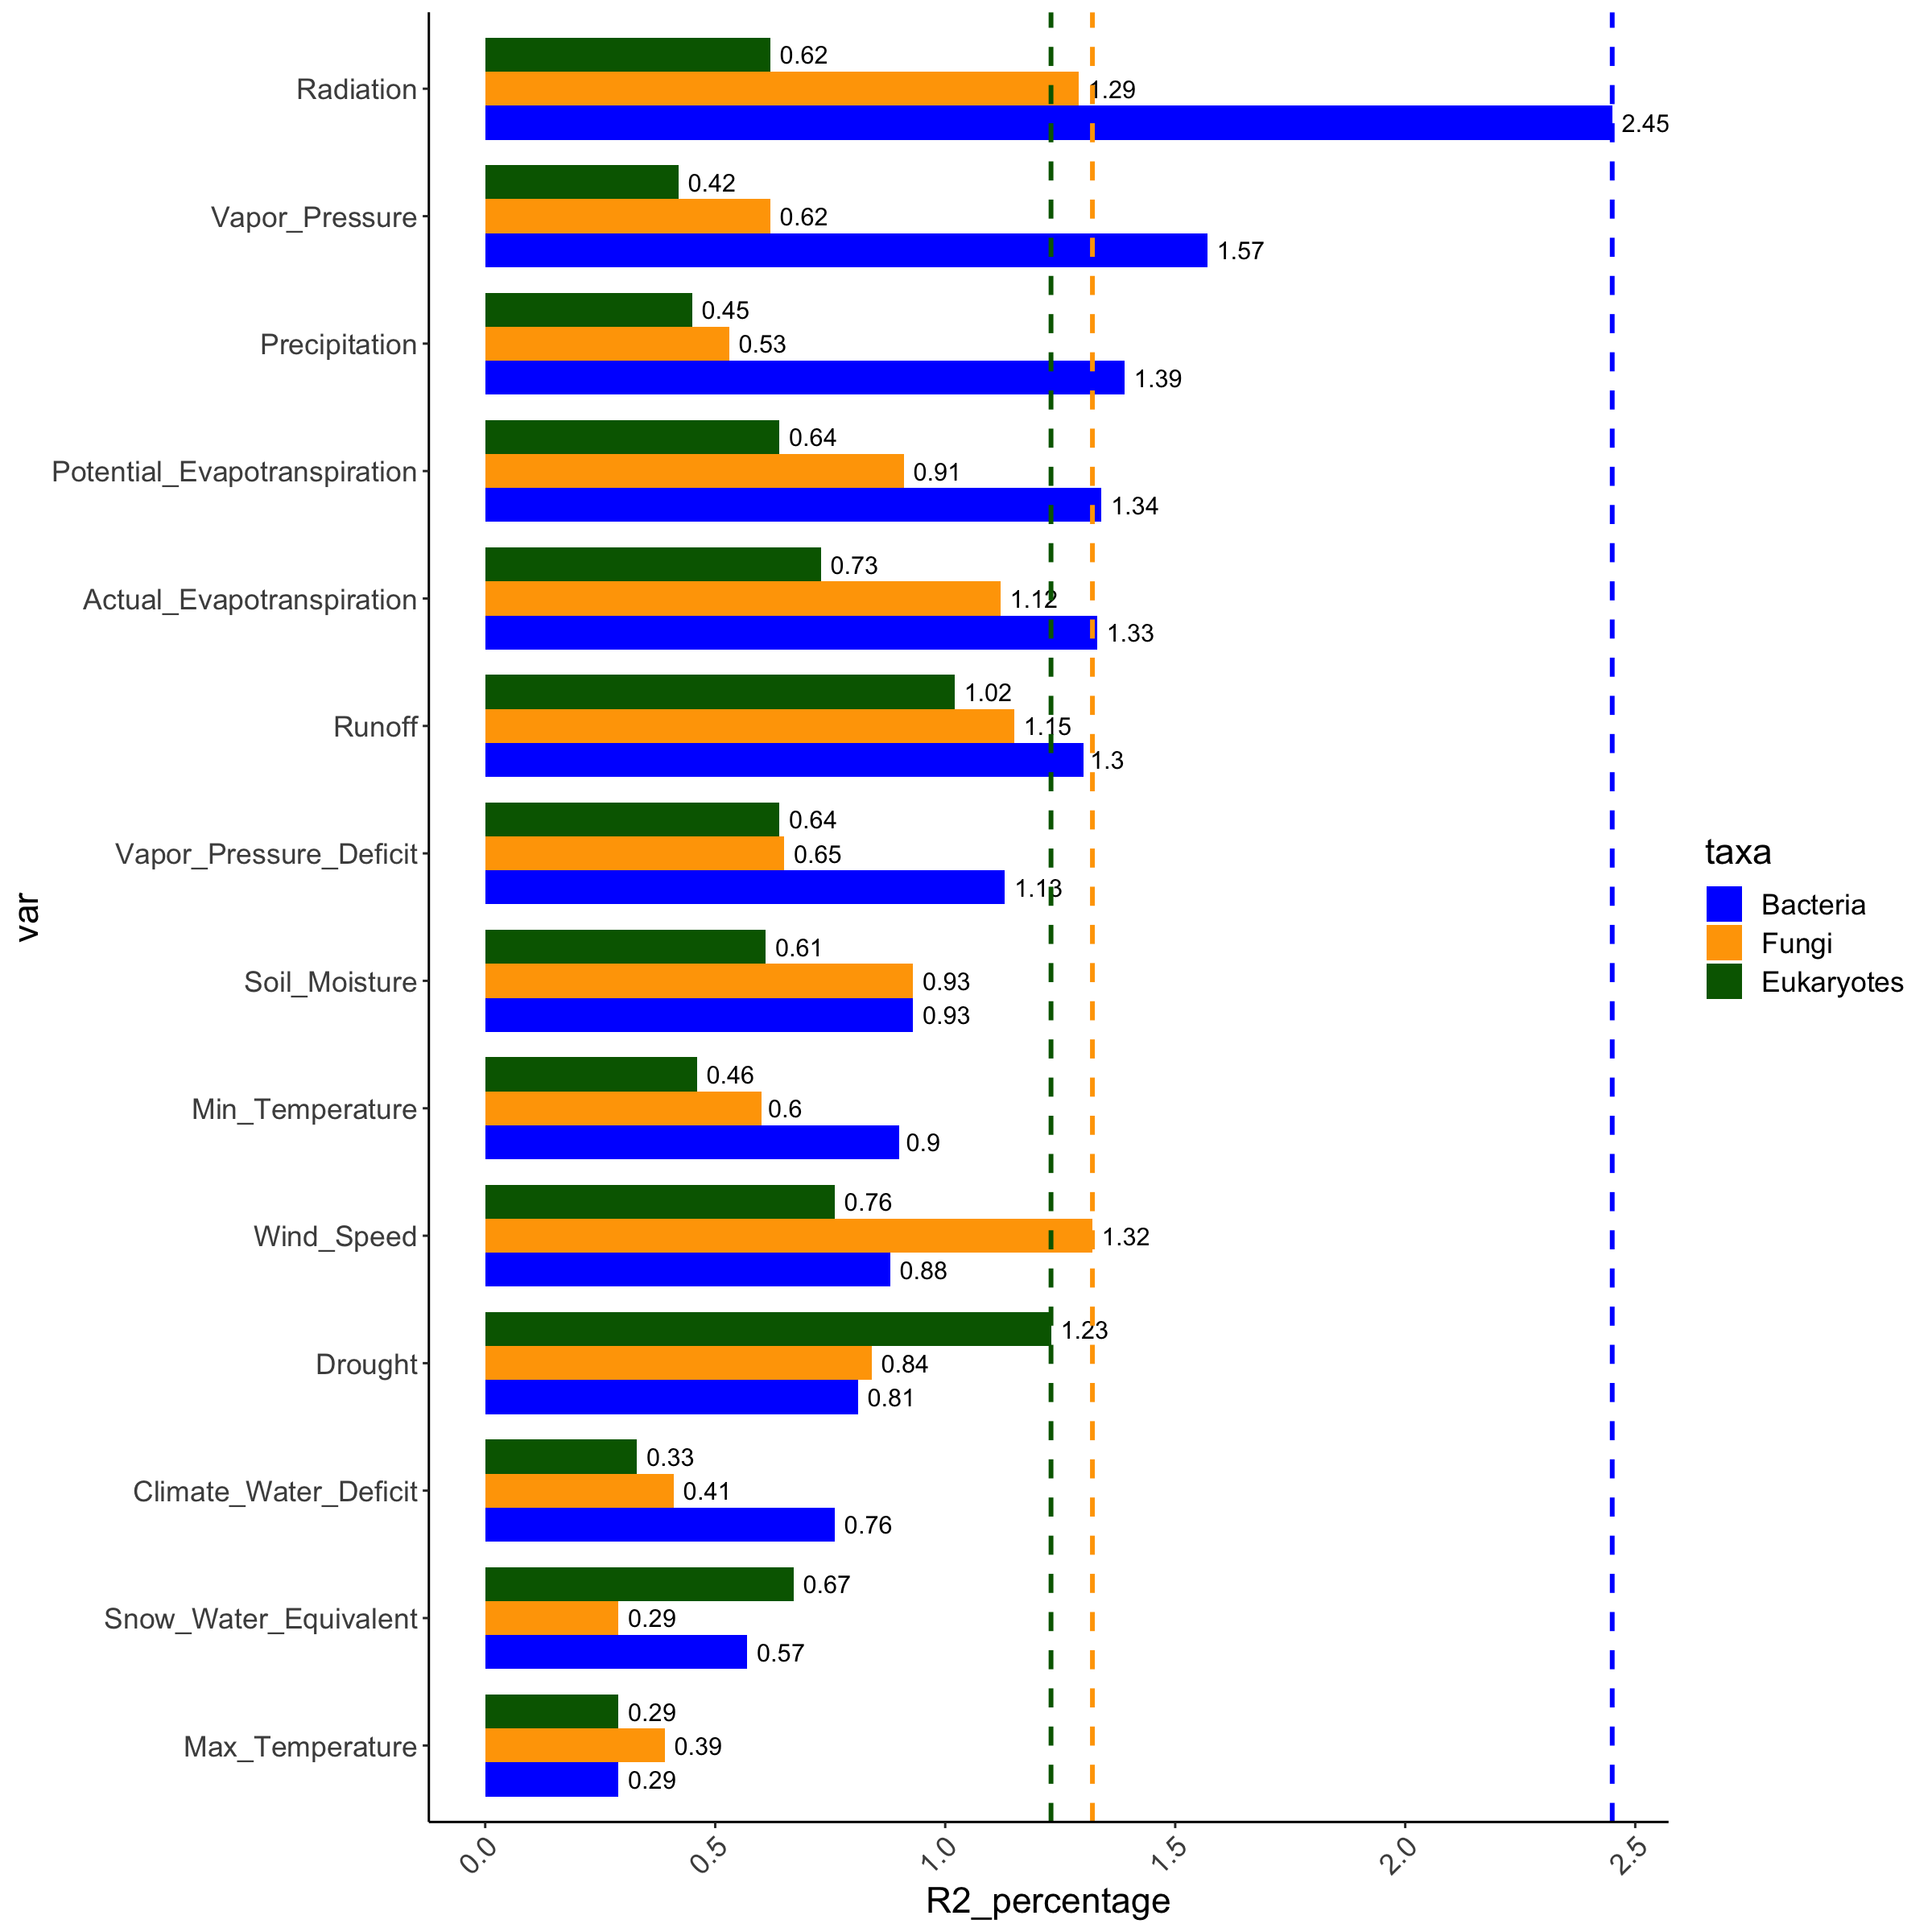

In [23]:

#open the permanova results file (or use variables from upper part) 

#Bacteria
B <- read.table("plots/B_env_ado.csv")
B =  B %>% drop_na()
B = B[order(B$R2,decreasing = TRUE),]
B$var = reorder(B$var ,B$R2)

#B

#Fungi
F <- read.table("plots/F_env_ado.csv")
F =  F %>% drop_na()
F = F[order(F$R2,decreasing = TRUE),]
F$var = reorder(F$var ,  B$R2)
#F

# Eukaryotes
O <- read.table("plots/E_env_ado.csv")
O =  O %>% drop_na()
O = O[order(O$R2,decreasing = TRUE),]
O$var = reorder(O$var ,  B$R2)
#O

# make a dataframe of all the results
df = rbind(B,F,O)
df$R2_percentage = round((df$R2 * 100) , digits =2)

#
#groupSum = df %>% 
#  group_by(var) %>% 
#  summarise(FrequencyR2 = sum(R2_percentage))

#groupSum = data.frame(groupSum[order(groupSum$FrequencyR2,decreasing = TRUE),])
#groupSum$var = reorder(groupSum$var , groupSum$FrequencyR2)

#groupSum

df = rbind(B,F,O)
df$R2_percentage = round((df$R2 * 100) , digits =2)
df$var = factor(df$var , levels=levels(factor(B$var)))
#levels(df$var)
#levels(groupSum$var)

df$label = round(df$R2_percentage , digits = 1)

df$taxa = factor(df$taxa , levels = c('Bacteria','Fungi' , 'Eukaryotes'))
hline = round(c(max((B$R2)*100), max((F$R2)*100) , max((O$R2)*100)) , digits = 2)
plt <- ggplot(data = df, aes(x = var, y = R2_percentage, fill = taxa)) +
    geom_col( position = position_dodge() , width = c(0.8)) +
    geom_text(aes(label = R2_percentage),
              position =position_dodge(width =0.8) , hjust = -0.2) +
theme_classic() + 
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank() , strip.background = element_blank() , text = element_text(size = 16) ,  panel.border = element_blank(),
     axis.text.x = element_text(angle = 45, vjust=1, hjust=1.01)) + 
scale_fill_manual(values = c("blue", "orange" , "darkgreen")) + 
geom_hline(yintercept=hline, linetype="dashed", 
                color = c("blue", "orange" , "darkgreen"), size=1) + coord_flip()

ggsave("plots/permanova_environmentalFactor.pdf",plt , width = 12 , height = 12)



options(repr.plot.width = 12, repr.plot.height =12, repr.plot.res = 200) 

plt 

df
write.table(df,"plots/env_adonis.csv",quote = FALSE , sep = "\t" , col.names = NA)

In [28]:
total_variation= df %>% 
group_by(taxa) %>% 
summarise(total_variation = sum(R2_percentage))
total_variation


write.table(total_variation,"plots/env_adonis_total_variation.csv",quote = FALSE , sep = "\t" , col.names = NA)

taxa,total_variation
<fct>,<dbl>
Bacteria,15.65
Fungi,11.05
Eukaryotes,8.87
